# 0. Data selection and necessary package importing
We select the SPDR Gold Shares (GLD) ETF as the gold ETF.

Similarly, we choose the SPDR Portfolio Europe ETF (SPEU) as the equity ETF.

The currency for Bitcoin is USD.


In [1]:
#IMPORT NECESSARY PACKAGES
import warnings
warnings.filterwarnings("ignore")
import arch
import holidays
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime, timedelta
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.vector_ar.vecm import VECM, coint_johansen, select_coint_rank
%matplotlib inline
from alpha_vantage.timeseries import TimeSeries
from pprint import pprint
import alpha_vantage

# 1.Data importing and pre-processing

In [2]:
start=datetime(2020,1,1)
end=datetime(2020,12,31)

In [3]:
#Alpha Vantage API key is: 4F24CEQQHYH5E8HW.
from alpha_vantage.timeseries import TimeSeries
ts = TimeSeries(key='4F24CEQQHYH5E8HW', output_format='pandas')


eqty_df, SPEU_meta_data = ts.get_daily_adjusted("SPEU", outputsize='full')
eqty_df=eqty_df.loc['2020-12-30':'2020-04-01']

eqty_df.rename(columns={'5. adjusted close': 'Adj Close'}, inplace=True)
pprint(eqty_df.head(2))


gold_df, GLD_meta_data = ts.get_daily_adjusted("GLD", outputsize='full')
gold_df=gold_df.loc['2020-12-30':'2020-04-01']
gold_df.rename(columns={'5. adjusted close': 'Adj Close'}, inplace=True)
pprint(gold_df.head(2))

            1. open  2. high  3. low  4. close  Adj Close  6. volume  \
date                                                                   
2020-12-30    38.19    38.33   38.00   38.0600  37.456118    26725.0   
2020-12-29    38.22    38.28   37.94   37.9701  37.367645    72732.0   

            7. dividend amount  8. split coefficient  
date                                                  
2020-12-30                 0.0                   1.0  
2020-12-29                 0.0                   1.0  
            1. open  2. high  3. low  4. close  Adj Close  6. volume  \
date                                                                   
2020-12-30   176.44   177.72  176.44    177.70     177.70  5914039.0   
2020-12-29   176.25   176.97  175.57    176.35     176.35  5983741.0   

            7. dividend amount  8. split coefficient  
date                                                  
2020-12-30                 0.0                   1.0  
2020-12-29                 0.0       

In [4]:
from alpha_vantage.cryptocurrencies import CryptoCurrencies
cc = CryptoCurrencies(key='4F24CEQQHYH5E8HW', output_format='pandas')

btc_df, BTC_meta_data = cc.get_digital_currency_daily(symbol='BTC', market='CNY')
btc_df=btc_df.loc['2020-12-30':'2020-04-01']

btc_df.rename(columns={'4b. close (USD)': 'Adj Close'}, inplace=True)
pprint(btc_df.head(2)) 


            1a. open (CNY)  1b. open (USD)  2a. high (CNY)  2b. high (USD)  \
date                                                                         
2020-12-30   177498.616000        27385.00     187940.4736         28996.0   
2020-12-29   175517.968672        27079.42     177660.6560         27410.0   

            3a. low (CNY)  3b. low (USD)  4a. close (CNY)  Adj Close  \
date                                                                   
2020-12-30     177077.312        27320.0    187159.700064   28875.54   
2020-12-29     167743.808        25880.0    177498.616000   27385.00   

               5. volume  6. market cap (USD)  
date                                           
2020-12-30  95356.057826         95356.057826  
2020-12-29  69411.592606         69411.592606  


In [5]:
btc_df.shape


(274, 10)

In [6]:
gold_df.shape

(190, 8)

In [7]:
eqty_df.shape

(190, 8)

In [8]:
missing = set(btc_df.index).symmetric_difference(set(gold_df.index))
def remove_missing_days(df, indices, missing):
    return df.loc[[index for index in indices if index not in missing]]

In [9]:
gold_df = remove_missing_days(gold_df, eqty_df.index, missing)
eqty_df = remove_missing_days(eqty_df, eqty_df.index, missing)
btc_df = remove_missing_days(btc_df, eqty_df.index, missing)


# 2. Data Processing

We use adjusted close prices to calculate the daily returns. Adjusted close prices are the prices that already take into account stock split and dividends, which reflex more accurate the change of the prices.

In [10]:
eqty_df["Daily Return"] = eqty_df["Adj Close"].pct_change(1)
eqty_df.loc['2020-4-1':].head()

1. open  2. high  3. low  4. close  Adj Close  6. volume  \
date                                                                   
2020-04-01    26.02    26.32   25.71     25.81  24.906872    15570.0   

            7. dividend amount  8. split coefficient  Daily Return  
date                                                                
2020-04-01                 0.0                   1.0     -0.015261

In [11]:
gold_df["Daily Return"] = gold_df["Adj Close"].pct_change(1)
gold_df.loc['2020-4-1':].head()

1. open  2. high  3. low  4. close  Adj Close   6. volume  \
date                                                                    
2020-04-01    148.2   150.08  147.85    149.45     149.45  11789096.0   

            7. dividend amount  8. split coefficient  Daily Return  
date                                                                
2020-04-01                 0.0                   1.0     -0.016129

In [12]:
btc_df["Daily Return"] = btc_df["Adj Close"].pct_change(1)
btc_df.loc['2020-4-1':].head()

1a. open (CNY)  1b. open (USD)  2a. high (CNY)  2b. high (USD)  \
date                                                                         
2020-04-01    41560.926624         6412.14    43296.699104         6679.94   

            3a. low (CNY)  3b. low (USD)  4a. close (CNY)  Adj Close  \
date                                                                   
2020-04-01   39862.552976        6150.11     43056.750272    6642.92   

             5. volume  6. market cap (USD)  Daily Return  
date                                                       
2020-04-01  97500.7524           97500.7524      -0.02225

In [13]:
from scipy.stats import norm, kurtosis

print("Gold adj close kurtosis is " ,kurtosis(gold_df['Adj Close']))
print("Eqty adj close kurtosis is " ,kurtosis(eqty_df['Adj Close']))
print("BTC adj close kurtosis is " ,kurtosis(btc_df['Adj Close']))

Gold adj close kurtosis is  -0.9037106518259126
Eqty adj close kurtosis is  -0.46988953758075747
BTC adj close kurtosis is  2.2409189556993407



import pmdarima
#automatically fit the optimal ARIMA model for given time series
arima_model_fitted = pmdarima.auto_arima(eqty_df.loc['2020-04-01':'2020-09-30','Adj Close'])
# one-step out-of sample forecast
forecast = arima_model_fitted.predict(n_periods=50)


In [14]:
eqty_df = eqty_df.iloc[::-1]


In [15]:

eqty_Q2_df=eqty_df.loc['2020-04-01':'2020-06-30','Adj Close'].to_frame()
eqty_Q2_np=eqty_Q2_df.to_numpy()

In [16]:


eqty_Q3_df=eqty_df.loc['2020-07-01':'2020-09-30','Adj Close'].to_frame()
eqty_Q3_np=eqty_Q3_df.to_numpy()

In [17]:
eqty_Q4_df=eqty_df.loc['2020-10-01':'2020-12-30','Adj Close'].to_frame()
eqty_Q4_np=eqty_Q4_df.to_numpy()

In [64]:
import pmdarima
import arch



# fit ARIMA on returns 
arima_model_fitted = pmdarima.auto_arima(eqty_Q2_np)
p, d, q = arima_model_fitted.order
arima_residuals = arima_model_fitted.arima_res_.resid

# fit a GARCH(1,1) model on the residuals of the ARIMA model
garch = arch.arch_model(arima_residuals, p=8, q=8)
garch_fitted = garch.fit()


# Use ARIMA to predict mu
predicted_mu = arima_model_fitted.predict(n_periods=len(eqty_Q2Q3_df)-len(eqty_Q3_np))
# Use GARCH to predict the residual
garch_forecast = garch_fitted.forecast(horizon=len(eqty_Q2Q3_df)-len(eqty_Q3_np),method='simulation')
predicted_et = garch_forecast.variance.values
predicted_et=predicted_et[-1,:]
# Combine both models' output: yt = mu + et
prediction = predicted_mu + predicted_et



Iteration:      1,   Func. Count:     20,   Neg. LLF: 34304701.30219266
Iteration:      2,   Func. Count:     40,   Neg. LLF: 10322938.625279225
Iteration:      3,   Func. Count:     60,   Neg. LLF: 3060.0571281153543
Iteration:      4,   Func. Count:     80,   Neg. LLF: 813.2364179858926
Iteration:      5,   Func. Count:    100,   Neg. LLF: 239.46386037907843
Iteration:      6,   Func. Count:    120,   Neg. LLF: 173.50300761811476
Iteration:      7,   Func. Count:    140,   Neg. LLF: 9657.832468047103
Iteration:      8,   Func. Count:    160,   Neg. LLF: 272.1843633191412
Iteration:      9,   Func. Count:    182,   Neg. LLF: 4484.700551795221
Iteration:     10,   Func. Count:    202,   Neg. LLF: 1285.8248200590094
Iteration:     11,   Func. Count:    222,   Neg. LLF: 458.5806478526168
Iteration:     12,   Func. Count:    242,   Neg. LLF: 223.84488211354085
Iteration:     13,   Func. Count:    263,   Neg. LLF: 2825.5901960140604
Iteration:     14,   Func. Count:    283,   Neg. LLF: 129

C:\Users\saverio\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\univariate\base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [65]:
fig=plt.figure(figsize=(9,7))
x=eqty_df.loc['2020-04-01':'2020-09-30','Adj Close'].to_frame().index


<Figure size 648x504 with 0 Axes>

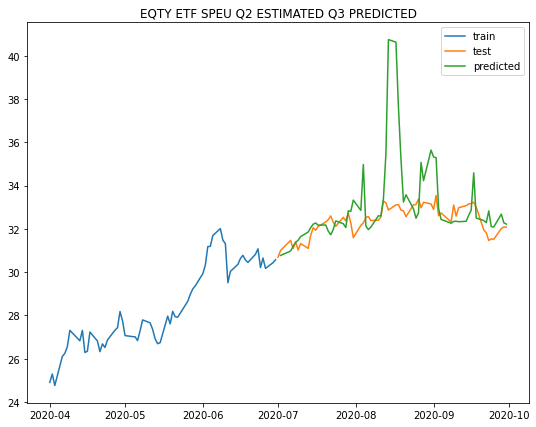

In [69]:
fig=plt.figure(figsize=(9,7))
plt.plot(x[:len(eqty_Q2_np)],eqty_Q2_np,label='train')
plt.plot(x[len(eqty_Q2_np):],eqty_Q3_np,label='test')
plt.title('EQTY ETF SPEU Q2 ESTIMATED Q3 PREDICTED')
plt.plot(x[len(eqty_Q2_np)+1:],prediction,label='predicted')
plt.legend()
plt.show()

In [21]:
import pmdarima
import arch



# fit ARIMA on returns 
arima_model_fitted = pmdarima.auto_arima(eqty_Q3_np)
p, d, q = arima_model_fitted.order
arima_residuals = arima_model_fitted.arima_res_.resid

# fit a GARCH(1,1) model on the residuals of the ARIMA model
garch = arch.arch_model(arima_residuals, p=10, q=10)
garch_fitted = garch.fit()


Iteration:      1,   Func. Count:     24,   Neg. LLF: 141.2826961690705
Iteration:      2,   Func. Count:     47,   Neg. LLF: 1991.6840814342086
Iteration:      3,   Func. Count:     71,   Neg. LLF: 121417.35478147073
Iteration:      4,   Func. Count:     95,   Neg. LLF: 125.83720776741579
Iteration:      5,   Func. Count:    119,   Neg. LLF: 81.99933500532451
Iteration:      6,   Func. Count:    142,   Neg. LLF: 339.5445135379198
Iteration:      7,   Func. Count:    169,   Neg. LLF: 342.6718836992789
Iteration:      8,   Func. Count:    193,   Neg. LLF: 48.71115032135296
Iteration:      9,   Func. Count:    216,   Neg. LLF: 71.60553976556339
Iteration:     10,   Func. Count:    241,   Neg. LLF: 463.97720439164743
Iteration:     11,   Func. Count:    265,   Neg. LLF: 41.35879716368055
Iteration:     12,   Func. Count:    288,   Neg. LLF: 1164.2044686680092
Iteration:     13,   Func. Count:    313,   Neg. LLF: 552.0332179473248
Iteration:     14,   Func. Count:    345,   Neg. LLF: 178.9

In [22]:


# Use ARIMA to predict mu
predicted_mu = arima_model_fitted.predict(n_periods=len(eqty_Q4_np))
# Use GARCH to predict the residual
garch_forecast = garch_fitted.forecast(horizon=len(eqty_Q4_np),method='simulation')
predicted_et = garch_forecast.variance.values
predicted_et=predicted_et[-1,:]
# Combine both models' output: yt = mu + et
prediction = predicted_mu + predicted_et



<Figure size 648x504 with 0 Axes>

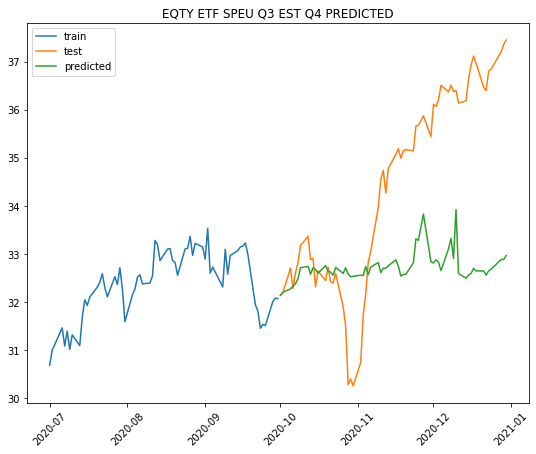

In [56]:

fig=plt.figure(figsize=(9,7))
x=eqty_df.loc['2020-07-01':'2020-12-30','Adj Close'].to_frame().index

fig=plt.figure(figsize=(9,7))
plt.plot(x[:len(eqty_Q3_np)],eqty_Q3_np,label='train')
plt.plot(x[len(eqty_Q3_np):],eqty_Q4_np,label='test')

plt.plot(x[len(eqty_Q3_np):],prediction,label='predicted')
plt.legend()
plt.title('EQTY ETF SPEU Q3 EST Q4 PREDICTED')
plt.xticks(rotation=45)
plt.show()

In [24]:
btc_df = btc_df.iloc[::-1]
gold_df = gold_df.iloc[::-1]


In [25]:

btc_Q2_df=btc_df.loc['2020-04-01':'2020-06-30','Adj Close'].to_frame()
btc_Q2_np=btc_Q2_df.to_numpy()


btc_Q3_df=btc_df.loc['2020-07-01':'2020-09-30','Adj Close'].to_frame()
btc_Q3_np=btc_Q3_df.to_numpy()


btc_Q2Q3_df=btc_df.loc['2020-04-01':'2020-09-30','Adj Close'].to_frame()
btc_Q2Q3_np=btc_Q2Q3_df.to_numpy()

btc_Q2Q3Q4_df=btc_df.loc['2020-04-01':'2020-12-30','Adj Close'].to_frame()
btc_Q2Q3Q4_np=btc_Q2Q3Q4_df.to_numpy()

eqty_Q2Q3_df=eqty_df.loc['2020-04-01':'2020-09-30','Adj Close'].to_frame()
eqty_Q2Q3_np=eqty_Q2Q3_df.to_numpy()

btc_Q4_df=btc_df.loc['2020-10-01':'2020-12-30','Adj Close'].to_frame()
btc_Q4_np=btc_Q4_df.to_numpy()

eqty_Q3Q4_df=eqty_df.loc['2020-07-01':'2020-12-30','Adj Close'].to_frame()
eqty_Q3Q4_np=eqty_Q4_df.to_numpy()

eqty_Q2Q3Q4_df=eqty_df.loc['2020-04-01':'2020-12-30','Adj Close'].to_frame()
eqty_Q2Q3Q4_np=eqty_Q2Q3Q4_df.to_numpy()

gld_Q3Q4_df=gold_df.loc['2020-07-01':'2020-12-30','Adj Close'].to_frame()
gld_Q3Q4_np=gld_Q3Q4_df.to_numpy()

gld_Q2Q3_df=gold_df.loc['2020-04-01':'2020-09-30','Adj Close'].to_frame()
gld_Q2Q3_np=gld_Q2Q3_df.to_numpy()

gld_Q2Q3Q4_df=gold_df.loc['2020-04-01':'2020-12-30','Adj Close'].to_frame()
gld_Q2Q3Q4_np=gld_Q2Q3Q4_df.to_numpy()

gld_Q4_df=gold_df.loc['2020-10-01':'2020-12-30','Adj Close'].to_frame()
gld_Q4_np=gld_Q4_df.to_numpy()

btc_Q3Q4_df=btc_df.loc['2020-07-01':'2020-12-30','Adj Close'].to_frame()
btc_Q3Q4_np=btc_Q4_df.to_numpy()

btc_Q2Q3Q4_df=btc_df.loc['2020-04-01':'2020-12-30','Adj Close'].to_frame()
btc_Q2Q3Q4_np=btc_Q2Q3Q4_df.to_numpy()

In [26]:
#creating the train and validation set
eqty_btc_Q2Q3_df = pd.DataFrame(index=eqty_Q2Q3_df.index)
eqty_btc_Q2Q3_np=np.column_stack((eqty_Q2Q3_np,btc_Q2Q3_np))
eqty_btc_Q2Q3_df=pd.DataFrame(data=eqty_btc_Q2Q3_np)


In [27]:
#checking stationarity
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.vecm import JohansenTestResult  
#johannason Cointegration test
vec_rank1 = select_coint_rank(eqty_btc_Q2Q3_df, det_order = 1, k_ar_diff = 1, method = 'trace')
print(vec_rank1.summary())
vec_rank2 = select_coint_rank(eqty_btc_Q2Q3_df, det_order = 1, k_ar_diff = 1, method = 'maxeig')
print(vec_rank2.summary())

###If t statistic < criticql value--> NUll not rejected. NUll for johqnse is that there are no cointegration

Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   2          9.158          18.40
-------------------------------------
Johansen cointegration test using maximum eigenvalue test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   1          6.102          17.15
-------------------------------------


In [28]:

train = eqty_btc_Q2Q3_df[:int(1*(len(eqty_Q2_np)))]
valid = eqty_btc_Q2Q3_df[int(1*(len(eqty_Q3_np))):]

train = pd.DataFrame(index=eqty_Q2_df.index)
train=np.column_stack((eqty_Q2_np,btc_Q2_np))
train=pd.DataFrame(data=train)

valid = pd.DataFrame(index=eqty_Q3_df.index)
valid=np.column_stack((eqty_Q3_np,btc_Q3_np))
valid=pd.DataFrame(data=valid)
#fit the model
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(endog=train)
model_fit = model.fit()

results = model.fit(8)

results.summary()
# make prediction on validation


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 26, Jul, 2021
Time:                     18:24:34
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    12.3690
Nobs:                     55.0000    HQIC:                   11.6079
Log likelihood:          -428.105    FPE:                    70958.4
AIC:                      11.1281    Det(Omega_mle):         41406.1
--------------------------------------------------------------------
Results for equation 0
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         1.601537         1.449099            1.105           0.269
L1.0          0.905580         0.174512            5.189           0.000
L1.1         -0.000047         0.000240           -0.198           0.843
L2.0          0.032879 

In [29]:
yhat = model_fit.forecast(model_fit.y, steps=len(valid))
yhat_df=pd.DataFrame(yhat)

(array([18353., 18383., 18414., 18444., 18475., 18506., 18536.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

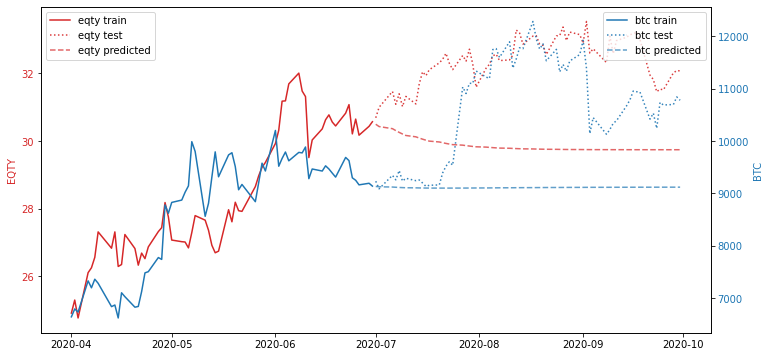

In [30]:
fig, y1_axis = plt.subplots(figsize=(12,6))

x=eqty_df.loc['2020-04-01':'2020-9-30','Adj Close'].to_frame().index



y1_color = 'tab:red'
y2_color = 'tab:blue'

y1_axis.plot(x[:len(eqty_Q2_np)],train.iloc[:,0],label='eqty train',color=y1_color)
y1_axis.plot(x[len(eqty_Q2_np):],valid.iloc[:,0],':',alpha=0.9,label='eqty test',color=y1_color)

y1_axis.plot(x[len(eqty_Q3_np)-1:],yhat_df.iloc[:,0],'--',alpha=0.7,label='eqty predicted',color=y1_color)

y1_axis.set_ylabel('EQTY', color=y1_color)
y1_axis.legend(loc='upper left')
y1_axis.tick_params(axis='y', labelcolor=y1_color)
y2_axis = y1_axis.twinx() 

y2_axis.set_ylabel('BTC', color=y2_color)

y2_axis.plot(x[:len(eqty_Q2_np)],train.iloc[:,1],label='btc train',color=y2_color)
y2_axis.plot(x[len(eqty_Q2_np):],valid.iloc[:,1],':',alpha=0.9,label='btc test',color=y2_color)

y2_axis.plot(x[len(eqty_Q3_np)-1:],yhat_df.iloc[:,1],'--',alpha=0.7,label='btc predicted',color=y2_color)
y2_axis.tick_params(axis='y', labelcolor=y2_color)
y2_axis.legend(loc='best')

plt.legend()
plt.xticks(rotation=45)


In [31]:
#creating the train and validation set


eqty_btc_Q3Q4_df = pd.DataFrame(index=eqty_Q3Q4_df.index)
eqty_btc_Q3Q4_np=np.column_stack((eqty_Q3Q4_np,btc_Q3Q4_np))
eqty_btc_Q3Q4_df=pd.DataFrame(data=eqty_btc_Q3Q4_np)


In [32]:

train = eqty_btc_Q3Q4_df[:int(1*(len(eqty_Q3_np)))]
valid = eqty_btc_Q3Q4_df[int(1*(len(eqty_Q4_np))):]

train = pd.DataFrame(index=eqty_Q3_df.index)
train=np.column_stack((eqty_Q3_np,btc_Q3_np))
train=pd.DataFrame(data=train)

valid = pd.DataFrame(index=eqty_Q4_df.index)
valid=np.column_stack((eqty_Q4_np,btc_Q4_np))
valid=pd.DataFrame(data=valid)
#fit the model
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(endog=train)
model_fit = model.fit()

results = model.fit(8)

results.summary()
# make prediction on validation


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 26, Jul, 2021
Time:                     18:24:35
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    11.0760
Nobs:                     56.0000    HQIC:                   10.3231
Log likelihood:          -400.619    FPE:                    19650.6
AIC:                      9.84635    Det(Omega_mle):         11563.9
--------------------------------------------------------------------
Results for equation 0
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const        16.478988         4.201792            3.922           0.000
L1.0          0.498593         0.163400            3.051           0.002
L1.1          0.000109         0.000152            0.716           0.474
L2.0          0.260876 

In [33]:
yhat = model_fit.forecast(model_fit.y, steps=len(valid))
yhat_df=pd.DataFrame(yhat)

(array([18444., 18475., 18506., 18536., 18567., 18597., 18628.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

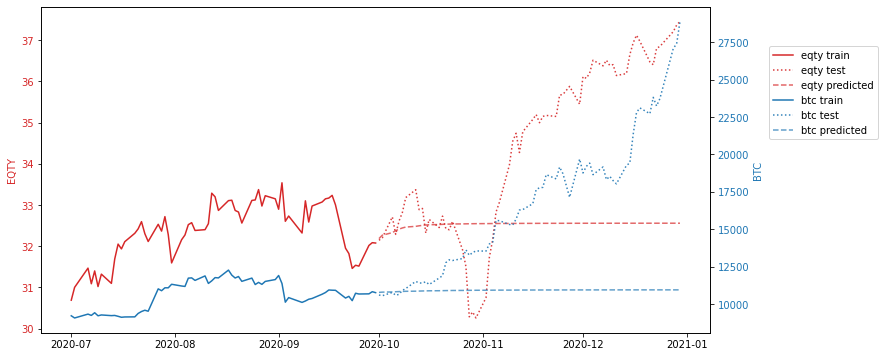

In [34]:
fig2, y1_axis = plt.subplots(figsize=(12,6))

x=eqty_df.loc['2020-07-01':'2020-12-30','Adj Close'].to_frame().index



y1_color = 'tab:red'
y2_color = 'tab:blue'

y1_axis.plot(x[:len(eqty_Q3_np)],train.iloc[:,0],label='eqty train',color=y1_color)
y1_axis.plot(x[len(eqty_Q3_np):],valid.iloc[:,0],':',alpha=0.9,label='eqty test',color=y1_color)

y1_axis.plot(x[len(eqty_Q3_np):],yhat_df.iloc[:,0],'--',alpha=0.7,label='eqty predicted',color=y1_color)

y1_axis.set_ylabel('EQTY', color=y1_color)

y1_axis.tick_params(axis='y',labelcolor=y1_color)


y2_axis = y1_axis.twinx() 

y2_axis.set_ylabel('BTC', color=y2_color)

y2_axis.plot(x[:len(eqty_Q3_np)],train.iloc[:,1],label='btc train',color=y2_color)
y2_axis.plot(x[len(eqty_Q3_np):],valid.iloc[:,1],':',alpha=0.9,label='btc test',color=y2_color)

y2_axis.plot(x[len(eqty_Q4_np)+1:],yhat_df.iloc[:,1],'--',alpha=0.7,label='btc predicted',color=y2_color)
y2_axis.tick_params(axis='y', labelcolor=y2_color)

# set legend position
fig2.legend(bbox_to_anchor=(1.1, 0.8))

plt.xticks(rotation=45)


In [35]:
#creating the train and validation set

eqty_btc_gld_Q2Q3Q4_df = pd.DataFrame(index=eqty_Q2Q3Q4_df.index)
eqty_btc_gld_Q2Q3Q4_np=np.column_stack((eqty_Q2Q3Q4_np,btc_Q2Q3Q4_np,gld_Q2Q3Q4_np))
eqty_btc_gld_Q2Q3Q4_df=pd.DataFrame(data=eqty_btc_gld_Q2Q3Q4_np)

In [36]:
eqty_btc_gld_Q2Q3_df = pd.DataFrame(index=eqty_Q2Q3_df.index)
eqty_btc_gld_Q2Q3_np=np.column_stack((eqty_Q2Q3_np,btc_Q2Q3_np,gld_Q2Q3_np))
eqty_btc_gld_Q2Q3_df=pd.DataFrame(data=eqty_btc_gld_Q2Q3_np)

In [37]:
eqty_btc_gld_Q4_df = pd.DataFrame(index=eqty_Q4_df.index)
eqty_btc_gld_Q4_np=np.column_stack((eqty_Q4_np,btc_Q4_np,gld_Q4_np))
eqty_btc_gld_Q4_df=pd.DataFrame(data=eqty_btc_gld_Q4_np)

In [38]:

train = eqty_btc_gld_Q2Q3_df[:int(1*(len(eqty_Q2Q3_np)))]
valid = eqty_btc_gld_Q4_df[int(1*(len(eqty_Q4_np))):]

train = pd.DataFrame(index=eqty_Q2Q3_df.index)
train=np.column_stack((eqty_Q2Q3_np,btc_Q2Q3_np,gld_Q2Q3_np))
train=pd.DataFrame(data=train)

valid = pd.DataFrame(index=eqty_Q4_df.index)
valid=np.column_stack((eqty_Q4_np,btc_Q4_np,gld_Q4_np))
valid=pd.DataFrame(data=valid)
#fit the model
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(endog=train)
model_fit = model.fit()

results = model.fit(8)

results.summary()
# make prediction on validation


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 26, Jul, 2021
Time:                     18:24:36
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    13.1235
Nobs:                     119.000    HQIC:                   12.0832
Log likelihood:          -1108.19    FPE:                    88520.5
AIC:                      11.3719    Det(Omega_mle):         49957.1
--------------------------------------------------------------------
Results for equation 0
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         1.359365         0.965756            1.408           0.159
L1.0          0.813024         0.109616            7.417           0.000
L1.1          0.000060         0.000158            0.382           0.702
L1.2         -0.031204 

In [39]:
yhat = model_fit.forecast(model_fit.y, steps=len(valid))
yhat_df=pd.DataFrame(yhat)

(array([18353., 18383., 18414., 18444., 18475., 18506., 18536., 18567.,
        18597., 18628.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

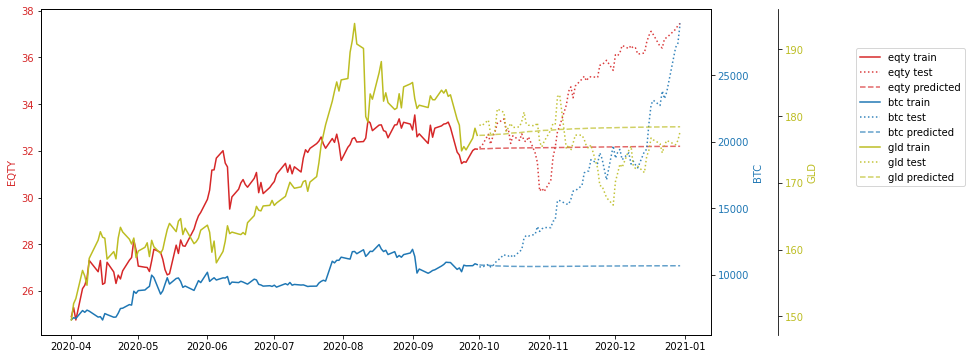

In [40]:
fig2, y1_axis = plt.subplots(figsize=(12,6))

x=eqty_df.loc['2020-04-01':'2020-12-30','Adj Close'].to_frame().index



y1_color = 'tab:red'
y2_color = 'tab:blue'
y3_color= 'tab:olive'

y1_axis.plot(x[:len(eqty_Q2Q3_np)],train.iloc[:,0],label='eqty train',color=y1_color)
y1_axis.plot(x[len(eqty_Q2Q3_np):],valid.iloc[:,0],':',alpha=0.9,label='eqty test',color=y1_color)

y1_axis.plot(x[len(eqty_Q2Q3_np+1):],yhat_df.iloc[:,0],'--',alpha=0.7,label='eqty predicted',color=y1_color)

y1_axis.set_ylabel('EQTY', color=y1_color)

y1_axis.tick_params(axis='y',labelcolor=y1_color)


y2_axis = y1_axis.twinx() 

y2_axis.set_ylabel('BTC', color=y2_color)

y2_axis.plot(x[:len(eqty_Q2Q3_np)],train.iloc[:,1],label='btc train',color=y2_color)
y2_axis.plot(x[len(eqty_Q2Q3_np):],valid.iloc[:,1],':',alpha=0.9,label='btc test',color=y2_color)

y2_axis.plot(x[len(eqty_Q2Q3_np):],yhat_df.iloc[:,1],'--',alpha=0.7,label='btc predicted',color=y2_color)
y2_axis.tick_params(axis='y', labelcolor=y2_color)



y3_axis = y1_axis.twinx() 
y3_axis.spines.right.set_position(("axes", 1.1))
y3_axis.set_ylabel('GLD', color=y3_color)

y3_axis.plot(x[:len(eqty_Q2Q3_np)],train.iloc[:,2],label='gld train',color=y3_color)
y3_axis.plot(x[len(eqty_Q2Q3_np):],valid.iloc[:,2],':',alpha=0.9,label='gld test',color=y3_color)

y3_axis.plot(x[len(eqty_Q2Q3_np):],yhat_df.iloc[:,2],'--',alpha=0.7,label='gld predicted',color=y3_color)
y3_axis.tick_params(axis='y', labelcolor=y3_color)
fig2.patch.set_facecolor('xkcd:white')


# set legend position
fig2.legend(bbox_to_anchor=(1.2, 0.8))

plt.xticks(rotation=45)


In [45]:
pip install mgarch


  Using cached mgarch-0.2.0.tar.gz (3.1 kB)Note: you may need to restart the kernel to use updated packages.



    ERROR: Command errored out with exit status 1:
     command: 'C:\Users\saverio\AppData\Local\Programs\Python\Python39\python.exe' -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\saverio\\AppData\\Local\\Temp\\pip-install-a7v7ewlz\\mgarch_bc4edd4446274fe4ae179252c7cfe93e\\setup.py'"'"'; __file__='"'"'C:\\Users\\saverio\\AppData\\Local\\Temp\\pip-install-a7v7ewlz\\mgarch_bc4edd4446274fe4ae179252c7cfe93e\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base 'C:\Users\saverio\AppData\Local\Temp\pip-pip-egg-info-ftqmz8j8'
         cwd: C:\Users\saverio\AppData\Local\Temp\pip-install-a7v7ewlz\mgarch_bc4edd4446274fe4ae179252c7cfe93e\
    Complete output (6 lines):
    Traceback (most recent call last):
      File "<string>", 